In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import json
import numpy as np
import os
import sys
import glob
import requests
import yahist
from yahist import Hist1D
from scipy.integrate import odeint
import scipy.optimize
import scipy.stats
import gzip
from tqdm.auto import tqdm
from utils import fit_exp

In [2]:
yahist.utils.set_default_style()

In [3]:
d_populations = {
"California": 39512223,
"Texas": 28995881,
"Florida": 21477737,
"New York": 19453561,
"Pennsylvania": 12801989,
"Illinois": 12671821,
"Ohio": 11689100,
"Georgia": 10617423,
"North Carolina": 10488084,
"Michigan": 9986857,
"New Jersey": 8882190,
"Virginia": 8535519,
"Washington": 7614893,
"Arizona": 7278717,
"Massachusetts": 6949503,
"Tennessee": 6833174,
"Indiana": 6732219,
"Missouri": 6137428,
"Maryland": 6045680,
"Wisconsin": 5822434,
"Colorado": 5758736,
"Minnesota": 5639632,
"South Carolina": 5148714,
"Alabama": 4903185,
"Louisiana": 4648794,
"Kentucky": 4467673,
"Oregon": 4217737,
"Oklahoma": 3956971,
"Connecticut": 3565287,
"Utah": 3205958,
"Puerto Rico": 3193694,
"Iowa": 3155070,
"Nevada": 3080156,
"Arkansas": 3017825,
"Mississippi": 2976149,
"Kansas": 2913314,
"New Mexico": 2096829,
"Nebraska": 1934408,
"West Virginia": 1792147,
"Idaho": 1787065,
"Hawaii": 1415872,
"New Hampshire": 1359711,
"Maine": 1344212,
"Montana": 1068778,
"Rhode Island": 1059361,
"Delaware": 973764,
"South Dakota": 884659,
"North Dakota": 762062,
"Alaska": 731545,
"District of Columbia": 705749,
"Vermont": 623989,
"Wyoming": 578759,
}

In [4]:
dfc = pd.read_csv("../sources/excessdeaths/data/data.csv.gz")
dfc

,Week Ending Date,State,Observed Number,Upper Bound Threshold,Exceeds Threshold,Average Expected Count,Excess Lower Estimate,Excess Higher Estimate,Year,Total Excess Lower Estimate in 2020,Total Excess Higher Estimate in 2020,Percent Excess Lower Estimate,Percent Excess Higher Estimate,Type,Outcome,Suppress,Note
0,2017-01-14,Alabama,1130.0,1199.0,False,1042.0,0.0,88.0,2017,208,744,0.0,0.1,Predicted (weighted),All causes,NaN,NaN
1,2017-01-21,Alabama,1048.0,1214.0,False,1057.0,0.0,0.0,2017,208,744,0.0,0.0,Predicted (weighted),All causes,NaN,NaN
2,2017-01-28,Alabama,1026.0,1233.0,False,1076.0,0.0,0.0,2017,208,744,0.0,0.0,Predicted (weighted),All causes,NaN,NaN
3,2017-02-04,Alabama,1036.0,1231.0,False,1074.0,0.0,0.0,2017,208,744,0.0,0.0,Predicted (weighted),All causes,NaN,NaN
4,2017-02-11,Alabama,1058.0,1224.0,False,1071.0,0.0,0.0,2017,208,744,0.0,0.0,Predicted (weighted),All causes,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38011,2020-04-25,Wyoming,97.0,110.0,False,90.0,0.0,7.0,2020,14,99,0.0,0.1,Unweighted,"All causes, excluding COVID-19",NaN,Data in recent weeks are incomplete. Only 60% ...
38012,2020-05-02,Wyoming,69.0,111.0,False,91.0,0.0,0.0,2020,14,99,0.0,0.0,Unweighted,"All causes, excluding COVID-19",NaN,Data in recent weeks are incomplete. Only 60% ...
38013,2020-05-09,Wyoming,83.0,112.0,False,93.0,0.0,0.0,2020,14,99,0.0,0.0,Unweighted,"All causes, excluding COVID-19",NaN,Data in recent weeks are incomplete. Only 60% ...
38014,2020-05-16,Wyoming,100.0,112.0,False,92.0,0.0,8.0,2020,14,99,0.0,0.1,Unweighted,"All causes, excluding COVID-19",NaN,Data in recent weeks are incomplete. Only 60% ...


In [5]:
dfc = pd.read_csv("../sources/excessdeaths/data/data.csv.gz")
# dfc = pd.read_csv("https://data.cdc.gov/api/views/xkkf-xrst/rows.csv?accessType=DOWNLOAD&bom=true&format=true%20target=")

dfc = dfc[(dfc["Type"] == "Predicted (weighted)")]
# dfc = dfc[(dfc["Type"] != "Predicted (weighted)")]

dfc = dfc.dropna(subset=["Observed Number"])

dfc["date"] = pd.to_datetime(dfc["Week Ending Date"])
dfc["state"] = dfc["State"]
dfc["observed"] = dfc["Observed Number"].astype(int)
dfc["threshold"] = dfc["Upper Bound Threshold"].astype(int)
dfc["excess"] = np.clip(dfc["observed"] - dfc["threshold"], 0, None)
dfc["excessin2020"] = dfc["Total Excess Higher Estimate in 2020"].fillna(0).astype(int)
dfc["type"] = dfc["Type"]
dfc["outcome"] = dfc["Outcome"]
dfc["withcovid"] = (dfc["outcome"] == "All causes")

dfc["isstate"] = ~(dfc["state"].str.contains("United States") | dfc["state"].str.contains(" City"))

dfc["population"] = dfc["state"].map(d_populations)

dfc = dfc[["date","withcovid","state","observed","threshold","excess","excessin2020","isstate","population"]]
dfc = dfc.set_index("date").sort_index()

In [6]:
dfc

,withcovid,state,observed,threshold,excess,excessin2020,isstate,population
date,,,,,,,,
2017-01-14,True,Alabama,1130,1199,0,744,True,4903185.0
2017-01-14,True,District of Columbia,127,141,0,564,True,705749.0
2017-01-14,True,Tennessee,1579,1637,0,516,True,6833174.0
2017-01-14,False,Indiana,1428,1471,0,523,True,6732219.0
2017-01-14,True,Florida,4337,4440,0,2807,True,21477737.0
...,...,...,...,...,...,...,...,...
2020-05-23,True,Maine,258,307,0,118,True,1344212.0
2020-05-23,False,Louisiana,694,956,0,873,True,4648794.0
2020-05-23,False,Kentucky,758,956,0,110,True,4467673.0


In [13]:
from ipywidgets import interact
def f(state="California"):
    fig, ax = plt.subplots(figsize=(8,4))
    # state = "Texas"
#     state = "Alaska"
    # state = "New York"
    # state = "New Jersey"
    df = dfc.query(f"state=='{state}'")

    df = df[df.index.year >= 2017]

    # get rid of last couple of data points as they are lacking inputs
    idx = dfc.index.unique().sort_values()[-1]
    df = df.loc[:idx]

    threshold = df.query("withcovid")["threshold"]
    obswithcovid = df.query("withcovid")["observed"]
    obswithoutcovid = df.query("not withcovid")["observed"]

    sf = (obswithoutcovid/threshold).median()
    threshcentral = (threshold*sf).round()

    threshold.plot(ax=ax,label="expected 95%CL threshold")
    threshcentral.plot(ax=ax,label="expected central (?)")
    obswithcovid.plot(ax=ax,label="observed with covid", color="r")
    obswithoutcovid.plot(ax=ax,label="observed without covid", color="k")
#     obswithoutcovid.plot(label="observed without covid", color="k", yerr=obswithoutcovid**0.5, linestyle="none", marker=".")

    # (obswithcovid-threshold).clip(lower=0.).cumsum().plot(color="k")

    excess_deaths_including_covid = (obswithcovid.loc["2020-03-01":]-threshcentral.loc["2020-03-01":]).clip(lower=0.).sum()
    excess_deaths_excluding_covid = (obswithoutcovid.loc["2020-03-01":]-threshcentral.loc["2020-03-01":]).clip(lower=0.).sum()
    excess_deaths_from_covid = excess_deaths_including_covid - excess_deaths_excluding_covid
    covid_frac = excess_deaths_from_covid / excess_deaths_including_covid
    print(covid_frac)

    ax.legend()
    ax.set_ylim(bottom=0.)
    ax.set_title(f"Excess deaths in {state}")
    
interact(f, state=sorted(dfc["state"].unique()))

interactive(children=(Dropdown(description='state', index=4, options=('Alabama', 'Alaska', 'Arizona', 'Arkansa…

<function __main__.f(state='California')>

In [8]:
def get_covid_deaths(state="California"):
    df = dfc.query(f"state=='{state}'")

    threshold = df.query("withcovid")["threshold"]
    obswithcovid = df.query("withcovid")["observed"]
    obswithoutcovid = df.query("not withcovid")["observed"]

    sf = (obswithoutcovid/threshold).median()
#     sf = 1
    threshcentral = (threshold*sf).round()

    excess_deaths_including_covid = (obswithcovid.loc["2020-03-01":]-threshcentral.loc["2020-03-01":]).clip(lower=0.).sum()
    excess_deaths_excluding_covid = (obswithoutcovid.loc["2020-03-01":]-threshcentral.loc["2020-03-01":]).clip(lower=0.).sum()
    excess_deaths_from_covid = excess_deaths_including_covid - excess_deaths_excluding_covid
    covid_frac = excess_deaths_from_covid / excess_deaths_including_covid
    return dict(fromcovid=excess_deaths_from_covid, fromall=excess_deaths_including_covid)

data = []
for state in dfc["state"].unique():
    if "City" in state: continue
    d = get_covid_deaths(state)
    data.append(dict(state=state, fromcovid=d["fromcovid"], fromall=d["fromall"]))
df = pd.DataFrame(data)

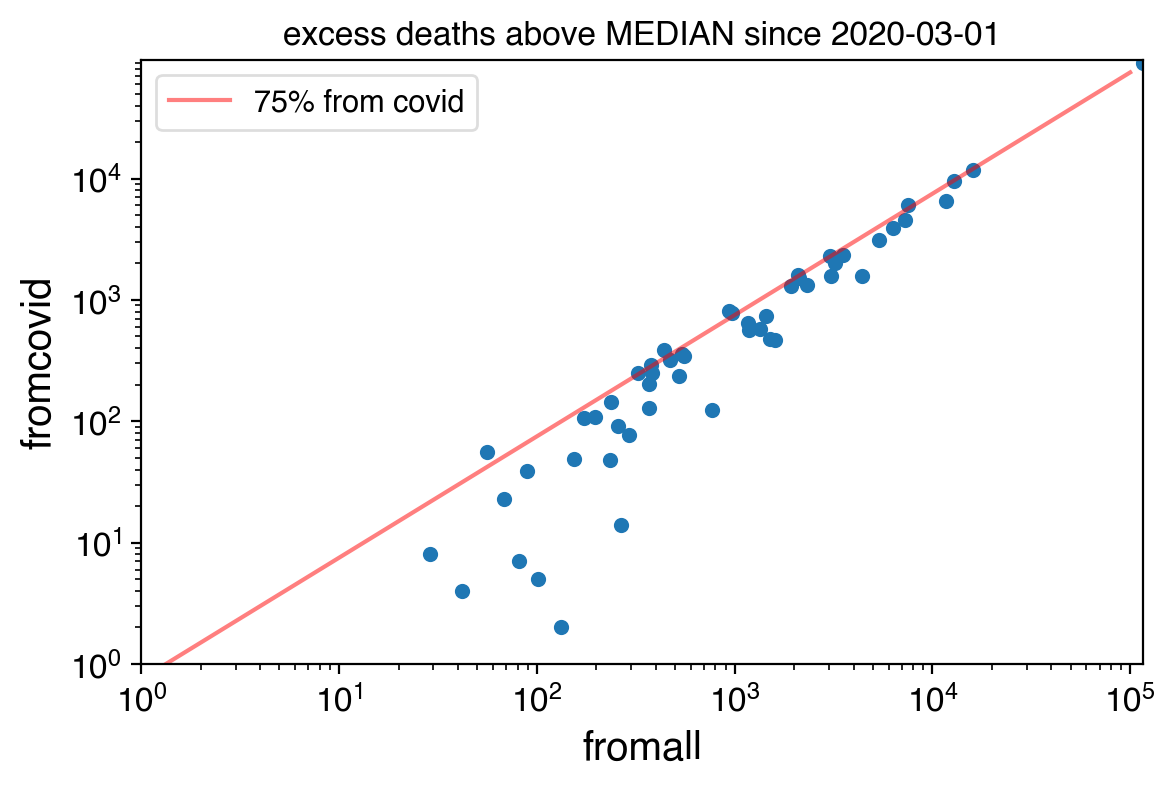

In [9]:
fig, ax = plt.subplots()
df.plot.scatter(ax=ax,x="fromall",y="fromcovid")

xs = np.linspace(1,1e5,100)
sf = 0.75
ys = xs*sf
ax.plot(xs,ys,color="red",label=f"{sf*100:.0f}% from covid", alpha=0.5)

ax.set_ylim(bottom=1.)
ax.set_xlim(left=1.)

ax.set_yscale("log")
ax.set_xscale("log")

ax.set_title("excess deaths above MEDIAN since 2020-03-01")

ax.legend()

No handles with labels found to put in legend.


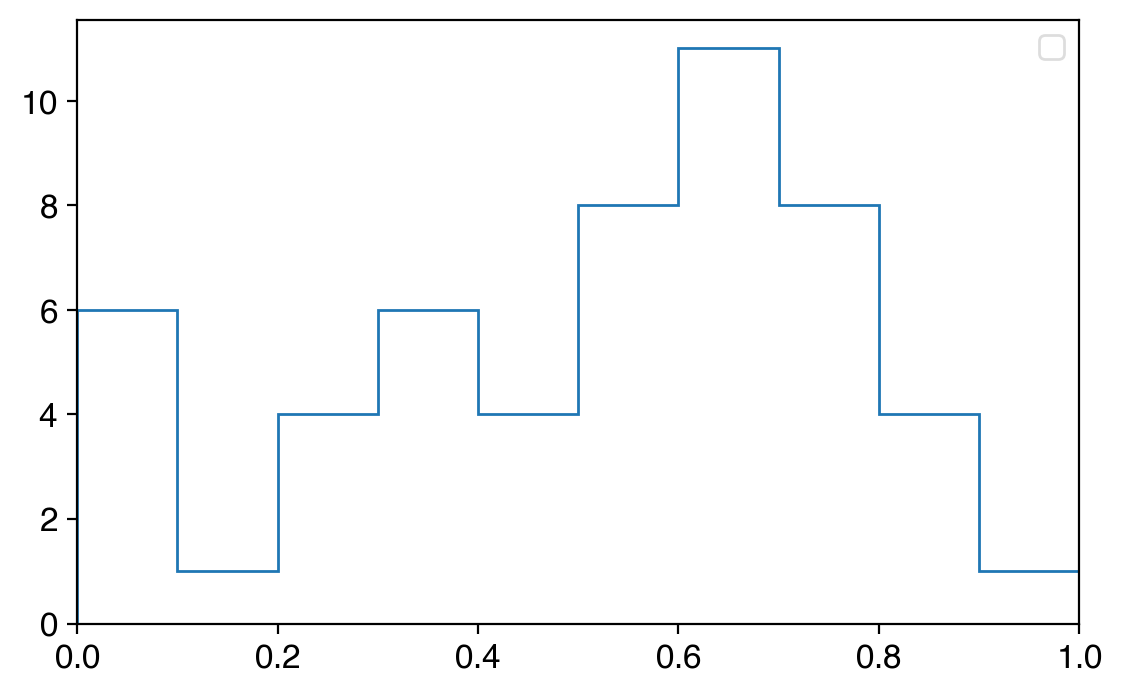

In [10]:
fig, ax = plt.subplots()

fracfromcovid = df["fromcovid"]/df["fromall"]
h = Hist1D(fracfromcovid, bins="10,0,1")
h.plot(histtype="step")

ax.legend()

In [244]:
# !pip3 install --user epysurv

In [245]:
# from epysurv import data as epidata
# from epysurv.models.timepoint import FarringtonFlexible
# train, test = epidata.salmonella()
# train.head()
# #             n_cases  n_outbreak_cases  outbreak
# # 2004-01-05        0                 0     False
# # 2004-01-12        0                 0     False
# # 2004-01-19        2                 0     False
# # 2004-01-26        2                 0     False
# # 2004-02-02        1                 0     False    
# model = FarringtonFlexible()
# model.fit(train)
# model.predict(test)
# #             n_cases  n_outbreak_cases  outbreak  alarm
# # 2011-01-03        1                 0     False    0.0
# # 2011-01-10        0                 0     False    0.0
# # 2011-01-17        3                 0     False    0.0
# # 2011-01-24        3                 0     False    0.0
# # 2011-01-31        3                 0     False    0.0


In [271]:
dfc["obsper100k"] = 100e3*dfc["observed"]/dfc["population"]

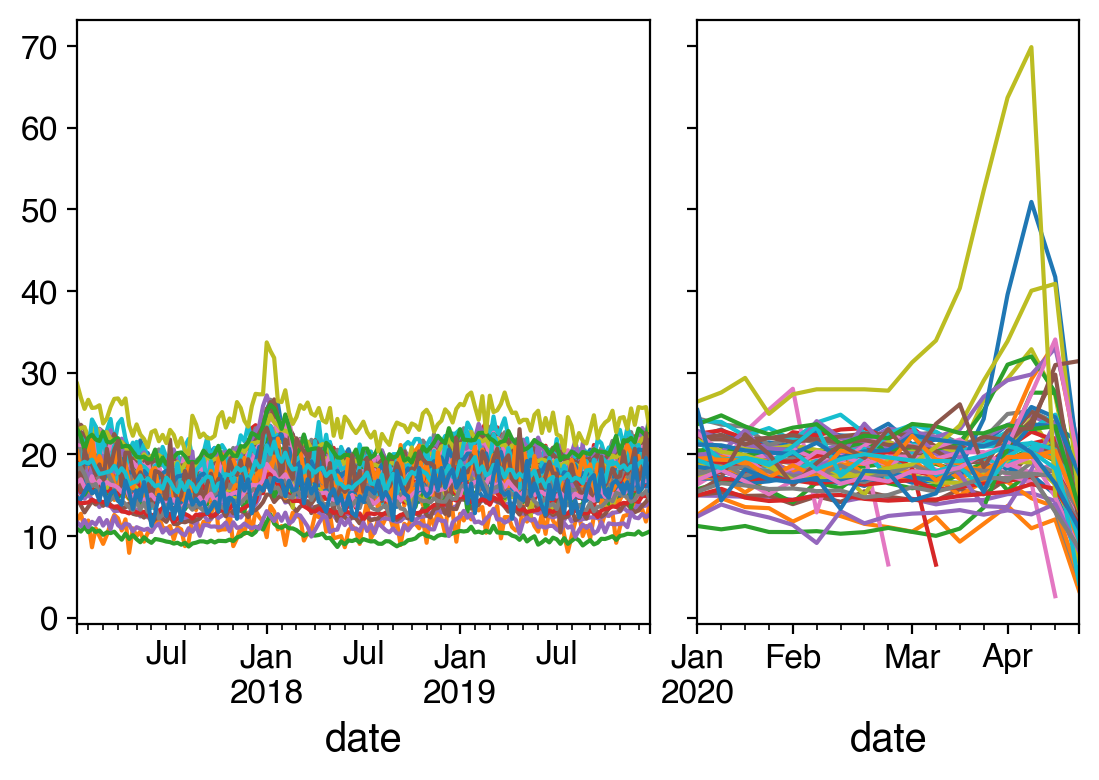

In [272]:
fig, (ax1,ax2) = plt.subplots(1,2, sharey=True, gridspec_kw=dict(width_ratios=[0.6,0.4]))
cutoff = "2020-01-01"

left = dfc.query("withcovid and isstate").loc[:cutoff].groupby("state")
right = dfc.query("withcovid and isstate").loc[cutoff:].groupby("state")
left = left["obsper100k"]
right = right["obsper100k"]
left.plot(ax=ax1);
right.plot(ax=ax2);
# ax.set_xscale("log")

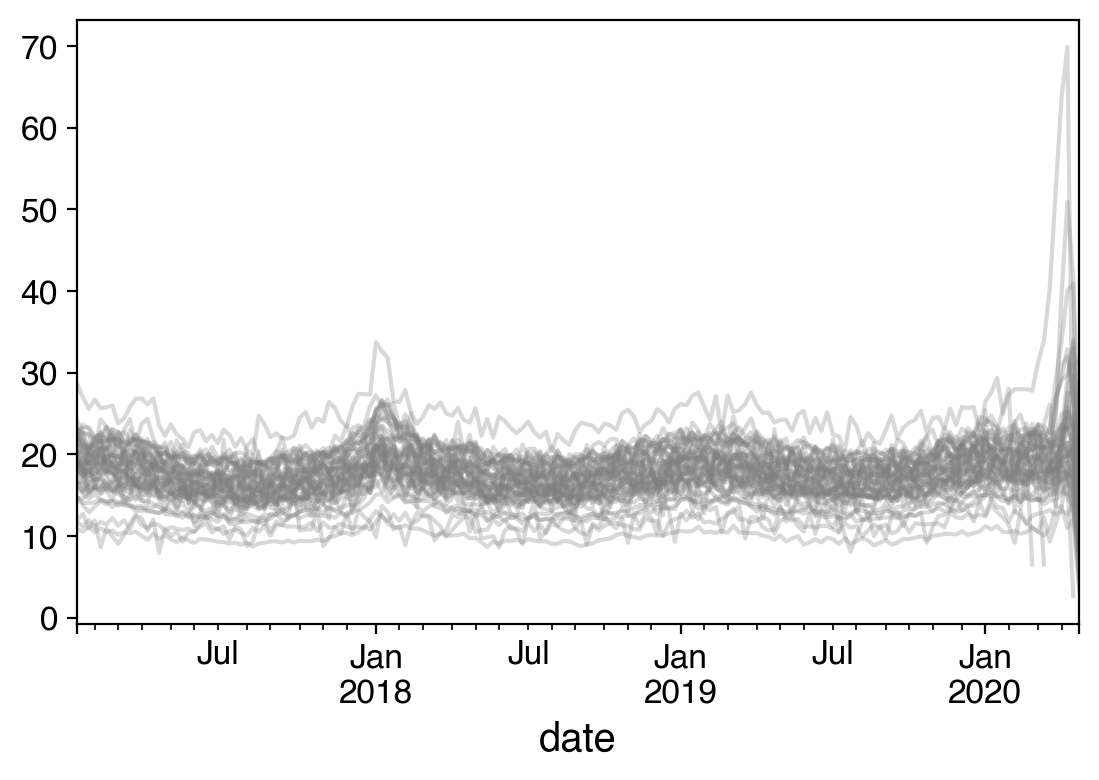

In [274]:
fig, ax = plt.subplots()

v = dfc.query("withcovid and isstate").groupby("state")["obsper100k"]
v.plot(ax=ax, color="gray",alpha=0.3);
# ax.set_xscale("log")

In [279]:
dfc.loc[:"2020-01-01"].query("withcovid and isstate").groupby("state")["obsper100k"].median().sort_values().head()

state
New York       9.787411
Utah          11.322669
Alaska        11.345850
California    12.803633
Colorado      13.058421
Name: obsper100k, dtype: float64

In [280]:
dfc.loc[:"2020-01-01"].query("withcovid and isstate").groupby("state")["obsper100k"].median().sort_values().tail()

state
Alabama          20.354117
Kentucky         20.458077
Tennessee        20.707800
Maine            20.904441
West Virginia    24.160964
Name: obsper100k, dtype: float64